# Data Preparation for the Nord_H2ub Spine Model

This jupyter notebook contains all routines for the preparation of the input data sources into a input data file for the model in Spine. 

**Authors:** Johannes Giehl (jfg.eco@cbs.dk), Dana Hentschel (djh.eco@cbs.dk)

## General settings

### Packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import math
import sys
import os
import pickle
import warnings
import re

### Methods:

In [2]:
#import the data preparation functions
# Determine the current working directory
module_path = os.getcwd()

if os.path.basename(module_path) != '00_functions':
# Set the module path (adjust the relative path if necessary)
    module_path = os.path.abspath(os.path.join(module_path, '00_functions'))
    if module_path not in sys.path:
        sys.path.append(module_path)

#load the functions and methods from the corresponding file
from nord_h2ub_data_preparation_functions import *
from nord_h2ub_data_preparation_main_functions import *

### Base parameters

In [3]:
with open(os.path.join(module_path, 'parameters.pkl'), 'rb') as file:
    parameters = pickle.load(file)

In [4]:
if not parameters:  
    print("Warning: No parameters were injected. Using default parameters only.")
    # Optionally, you could provide some default initialization here.

(year, start_date, end_date, area, product, scenario, frequency, 
            model_name, temporal_block, stochastic_scenario, stochastic_structure, 
            report_name, reports, 
            electrolyzer_type, des_segments_electrolyzer, 
            share_of_dh_price_cap, price_level_power, power_price_variance, 
            roll_forward_use, roll_forward_size, num_slices, datetime_index, 
            candidate_nonzero, investment_period_default, 
            inv_cost_Ammonia_storage, inv_cost_anaerobic, inv_cost_asu, inv_cost_biomethanation,
 inv_cost_co2_removal, inv_cost_egasoline_storage, inv_cost_Electrolyzer, inv_cost_Fischer_Tropsch_unit, 
 inv_cost_Haber_Bosch_reactor, inv_cost_Hydrogen_storage, inv_cost_Jet_fuel_storage, inv_cost_Methane_storage, 
 inv_cost_Methanol_Plant, inv_cost_Methanol_storage, inv_cost_RWGS_unit, inv_cost_Electric_Steam_Boiler) = set_parameters(parameters)

### File paths

In [5]:
#set path to correct folders
'''still not working if it is not started from this jupyter notebook'''
#input data
excel_file_path = get_excel_file_path() + '/01_input_raw/'
#prepared input data
output_file_path = get_excel_file_path() + '/02_input_prepared/'

In [6]:
#set name of the relevant files

Model_structure_file = '/Model_Data_Base_' + product + '.xlsx'
efficiency_electrolyzer_file = '/Efficiency_Electrolyzers.xlsx'
distric_heating_price_file = 'energy_prices/district_heating_price_cap.xlsx'
investment_costs_file = '/investment_cost_overview/Investment_cost_overview.xlsx'
mapping_file = '/methanol_object_mapping.xlsx'

PV_data_availabilityfactors = 'PV_availability_factors_Kasso.xlsx'
data_powerprices = 'Day_ahead_prices_' + str(year) + '.xlsx'

#output file
output_file_name = product + '_Input_prepared.xlsx'
output_mapping_file_name = product + '_object_mapping.xlsx'


## Workflow of the data preparation

### General parameters

In [7]:
#date index
date_index = pd.date_range(start=start_date, end=end_date, freq='h')
formatted_dates = date_index.strftime('%Y-%m-%dT%H:%M:%S')
df_formatted_dates = pd.DataFrame(formatted_dates, columns=['DateTime'])

df_time = pd.DataFrame(df_formatted_dates)

### Data import

In [8]:
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

#Model structure
df_model_units_raw = pd.read_excel(excel_file_path + product + Model_structure_file, sheet_name='Units', index_col=None)
df_model_connections_raw = pd.read_excel(excel_file_path + product + Model_structure_file, sheet_name='Connections', index_col=None)
df_model_storages_raw = pd.read_excel(excel_file_path + product + Model_structure_file, sheet_name='Storages', index_col=None)

#Variable efficiency
df_efficiency_electrolyzer = pd.read_excel(excel_file_path + product + efficiency_electrolyzer_file, sheet_name='Efficiency_'+electrolyzer_type)

#Availability factor
df_PV_availabilityfactors_values = pd.read_excel(excel_file_path+PV_data_availabilityfactors, skiprows=2, usecols=[0,1,2,3,4,5])

#Power prices
df_powerprices_total_values = pd.read_excel(excel_file_path+data_powerprices)
#only extracting the prices from our earlier defined area
df_powerprices_values = df_powerprices_total_values[df_powerprices_total_values['PriceArea'] == area]
df_powerprices_values = df_powerprices_values.reset_index(drop=True)

#District heating prices
df_district_heating_price = pd.read_excel(excel_file_path + distric_heating_price_file, sheet_name='Price_Cap_Calculation', index_col=None)

#Investment costs
df_investment_costs_raw = pd.read_excel(excel_file_path + investment_costs_file, sheet_name='Investment_Cost', index_col=None)

#Mapping between entity and parameter name
df_mapping = pd.read_excel(excel_file_path + product + mapping_file, sheet_name='Object_Mapping', index_col=None)

### Adjustments

#### Adjust base elements:

In [9]:
#drop some unnecessary information
df_model_units = df_model_units_raw.drop(columns = ['Object_type']).copy()
df_model_connections = df_model_connections_raw.drop(columns = ['Object_type']).copy()
df_model_storages = df_model_storages_raw.drop(columns = ['Object_type']).copy()

#create mapping tables for object name to type
df_model_units_mapping = df_model_units_raw[['Unit', 'Object_type']].copy()
df_model_connections_mapping = df_model_connections_raw[['Connection', 'Object_type']].copy()
df_model_storages_mapping = df_model_storages_raw[['Storage', 'Object_type']].copy()

df_model_units_mapping.rename(columns={'Unit': 'Object_Name'}, inplace=True)
df_model_connections_mapping.rename(columns={'Connection': 'Object_Name'}, inplace=True)
df_model_storages_mapping.rename(columns={'Storage': 'Object_Name'}, inplace=True)

#create a dataframe with mapping of all object in the model
df_model_object_mapping = pd.concat([df_model_units_mapping, df_model_connections_mapping, df_model_storages_mapping], axis=0)
df_model_object_mapping = df_model_object_mapping.reset_index(drop=True)

In [10]:
#Adjust time by transforming years/months etc into days
df_model_units['unit_investment_tech_lifetime'] = df_model_units['unit_investment_tech_lifetime'].apply(lambda x: convert_to_days(x, year))
df_model_connections['connection_investment_tech_lifetime'] = df_model_connections['connection_investment_tech_lifetime'].apply(lambda x: convert_to_days(x, year))
df_model_storages['storage_investment_tech_lifetime'] = df_model_storages['storage_investment_tech_lifetime'].apply(lambda x: convert_to_days(x, year))

In [11]:
df_units = process_dataframe(df_model_units, 'Unit', 'unit')
df_connections = process_dataframe(df_model_connections, 'Connection', 'connection')

In [12]:
#adjust the storage loss rate values to fit to the SpineOpt implementation
df_model_storages = adjust_frac_state_loss(df_model_storages, 'frac_state_loss')

In [13]:
#define the elements of the network
df_definition, df_nodes = create_definition_dataframe(df_model_units, df_model_connections)

In [14]:
#create a data frame for all parameters of units

#add fixed operation and maintenance cost
unit_fom_cost_df = create_unit_parameters(df_model_units, 'Unit', 'fom_cost')
#add unit minimal downtime
unit_min_down_time_df = create_unit_parameters(df_model_units, 'Unit', 'min_down_time')
#add unit on cost (Set to 0 if no entry was made)
df_model_units['units_on_cost'] = df_model_units['units_on_cost'].fillna(0)
unit_on_cost_df = create_unit_parameters(df_model_units, 'Unit', 'units_on_cost')


connection_fom_cost_df = create_unit_parameters(df_model_connections, 'Connection', 'fom_cost')

#create a complete data frame with all parameters
unit_parameters_df = pd.concat([unit_fom_cost_df, unit_on_cost_df, unit_min_down_time_df, connection_fom_cost_df], ignore_index=True)
unit_parameters_df.head()

,Object_Name,Category,parameter,value
0,Solar_Plant_Kasso,unit,fom_cost,1.29
1,Electrolyzer,unit,fom_cost,4.34
2,Methanol_Reactor,unit,fom_cost,4.45
3,Steam_Plant,unit,fom_cost,0.119292
4,Solar_Plant_Kasso,unit,units_on_cost,0.0


In [15]:
#create a new data frame for parameters that are given as durations
#necessary as SpineToolbox needs a separate input to map the parameter correctly

duration_parameter = 'min_down_time'
unit_parameters_duration_df = unit_parameters_df[unit_parameters_df['parameter'] == duration_parameter]
# Resetting the index
unit_parameters_duration_df = unit_parameters_duration_df.reset_index(drop=True)

# Creating another DataFrame with rows that do not meet the condition
unit_parameters_rest_df = unit_parameters_df[unit_parameters_df['parameter'] != duration_parameter]

In [16]:
#create the balance type of the nodes
columns_to_select = ['Input1', 'Input2', 'Output1', 'Output2']
df_combined = pd.concat([df_model_units, df_model_connections])
df_combined = df_combined.reset_index(drop=True)

df_nodes_network = create_connection_dataframe(df_combined, columns_to_select)

# Get unique values from the 'in' column
unique_in_values = df_nodes_network['in'].dropna().unique()

# Identify values in 'in' column not present in 'out' column
values_not_in_out = unique_in_values[~pd.Series(unique_in_values).isin(df_nodes_network['out'].dropna().unique())]

# Get unique values from the 'in' column
unique_out_values = df_nodes_network['out'].dropna().unique()

# Identify values in 'in' column not present in 'out' column
values_not_in_in = unique_out_values[~pd.Series(unique_out_values).isin(df_nodes_network['in'].dropna().unique())]

#create list of unique nodes that are either start or end nodes
unique_nodes = values_not_in_out.tolist() + values_not_in_in.tolist()
unique_nodes

df_nodes_network.replace(np.nan, None, inplace=True)

#check for combinations that are mirrored
mirrored_combinations = find_mirror_combinations(df_nodes_network)

#get information of connections for each node
partners_dict1 = find_partners(df_nodes_network)
partners_dict2 = find_partners(mirrored_combinations)

#check both lists if there are identical entries and list nodes that only have a connection to the same node
#storages are removed as they must be balanced
nodes_identical = find_identical_entries(partners_dict1, partners_dict2)

#combined list of start and end nodes that should be unbalanced
unbalanced_nodes = nodes_identical + unique_nodes

df_nodes['balance_type'] = 'balance_type_node'
df_nodes.loc[df_nodes['Object_Name'].isin(unbalanced_nodes), 'balance_type'] = 'balance_type_none'

In [17]:
#add has_state_node_state_cap and frac_state_loss
df_storages_short = df_model_storages.loc[:, ['Storage', 'has_state', 'node_state_cap', 'frac_state_loss']].rename(columns={'Storage': 'Object_Name'})
df_storages_short['has_state'] = df_storages_short['has_state'].astype(str).str.lower().replace('true', 'true')

df_nodes = pd.merge(df_nodes, df_storages_short, on='Object_Name', how='left')
df_nodes['demand'] = ""

In [18]:
#create a dataframe with all nodes that should have a slack based on the unit input and outputs
nodes_for_slack_df = check_entries_exist(df_model_units, 'node')
#merge the information into the prepared data frame
merged_df = pd.merge(df_nodes, nodes_for_slack_df, left_on='Object_Name', right_on='node', how='left')
merged_df = merged_df.drop(columns=['node'])
merged_df['node_slack_penalty'] = merged_df['node_slack_penalty'].replace({True: 1000000, False: ''})
#create a dataframe with all nodes that should have a slack based on the connection input and outputs
nodes_for_slack_df2 = check_entries_exist(df_model_connections, 'connection')
#merge the information into the prepared data frame
merged_df2 = pd.merge(df_nodes, nodes_for_slack_df2, left_on='Object_Name', right_on='connection', how='left')
merged_df2 = merged_df2.drop(columns=['connection'])
merged_df2['node_slack_penalty'] = merged_df2['node_slack_penalty'].replace({True: 1000000, False: ''})
#link the information about the slack of both data frames
merged_df2['node_slack_penalty'] = merged_df['node_slack_penalty'].combine_first(merged_df2['node_slack_penalty'])
#clean the information that only nodes with 'balance_type_node' have a penalty
merged_df2.loc[merged_df2['balance_type'] == 'balance_type_none', 'node_slack_penalty'] = ''
#add the information into the df_nodes
df_nodes['node_slack_penalty'] = merged_df2['node_slack_penalty']

#show table head for control
df_nodes.head()

,Object_Name,Category,balance_type,has_state,node_state_cap,frac_state_loss,demand,node_slack_penalty
0,Carbon_Dioxide,node,balance_type_none,NaN,NaN,NaN,,
1,Waste_Heat,node,balance_type_node,NaN,NaN,NaN,,
2,Hydrogen_storage_Kasso,node,balance_type_node,true,5478.676451,0.043264,,1000000
3,E-Methanol_storage_Kasso,node,balance_type_node,true,2640.000000,0.000000,,1000000
4,Water,node,balance_type_none,NaN,NaN,NaN,,


#### Investments:

In [19]:
#Create a dataframe for the units' investment parameters
df_units_inv_parameters = df_model_units.loc[:, ['Unit']].rename(columns={'Unit': 'Object_Name'})
df_units_inv_parameters['unit_investment_variable_type'] = 'unit_investment_variable_type_continuous'
df_units_inv_parameters['initial_units_invested_available'] = 0
df_units_inv_parameters['number_of_units'] = df_model_units['number_of_units']
df_units_inv_parameters['candidate_units'] = 1

#Choose closest investment costs based on year
year_columns = {int(col.split()[-1]): col for col in df_investment_costs_raw.columns if 'Value' in col}
closest_year = min(year_columns.keys(), key=lambda x: abs(x - year))
selected_column = year_columns[closest_year]

#Scale investment costs from MW to unit
df_units_inv_parameters['unit_investment_cost'] = None

for index, row in df_model_units_raw.iterrows():
    object_type = row['Object_type']
    if object_type in ['PEM_Electrolyzer', 'AEC_Electrolyzer', "SOEC_Electrolyzer"]:
        object_type = 'Electrolyzer'
    
    cap_input = row['Cap_Input1_existing'] if not pd.isna(row['Cap_Input1_existing']) else 0
    cap_output = row['Cap_Output1_existing'] if not pd.isna(row['Cap_Output1_existing']) else 0
    
    # Default investment cost
    matching_row = df_investment_costs_raw[df_investment_costs_raw['Object_type'] == object_type]
    if not matching_row.empty:
        # Extract the investment cost from the selected_column
        investment_cost = matching_row[selected_column].values[0]
    default_value = investment_cost * (cap_input + cap_output)
    
    # Check if external investments costs given
    pattern = re.compile(rf"inv_cost_.*{object_type}")
    matching_vars = [var for var in globals() if pattern.match(var)]
    
    if matching_vars:
        variable_name = matching_vars[0]
        variable_value = globals()[variable_name]
        
        if variable_value is not None:
            special_value = variable_value * (cap_input + cap_output)
            df_units_inv_parameters.at[index, 'unit_investment_cost'] = special_value
        else:
            df_units_inv_parameters.at[index, 'unit_investment_cost'] = default_value
    else:
        # If no matching variable, use the default calculation
        df_units_inv_parameters.at[index, 'unit_investment_cost'] = default_value

df_units_inv_parameters['unit_investment_tech_lifetime'] = df_model_units['unit_investment_tech_lifetime']

#Scale investment costs to lifetime
df_units_inv_parameters = scale_costs(df_units_inv_parameters, start_date, end_date, 'unit')

# Add economical investment lifetime and set to same value as the technical lifetime
df_units_inv_parameters['unit_investment_econ_lifetime'] = df_units_inv_parameters['unit_investment_tech_lifetime']

#show table head for control
df_units_inv_parameters.head()

,Object_Name,unit_investment_variable_type,initial_units_invested_available,number_of_units,candidate_units,unit_investment_cost,unit_investment_tech_lifetime,unit_investment_econ_lifetime
0,Solar_Plant_Kasso,unit_investment_variable_type_continuous,0,0,1,4850673.972603,12775D,12775D
1,Electrolyzer,unit_investment_variable_type_continuous,0,0,1,0.0,9125D,9125D
2,CO2_Vaporizer,unit_investment_variable_type_continuous,0,0,1,2493150.684932,7300D,7300D
3,Destilation_Tower,unit_investment_variable_type_continuous,0,0,1,864292.237443,10950D,10950D
4,Methanol_Reactor,unit_investment_variable_type_continuous,0,0,1,2333589.041096,10950D,10950D


In [20]:
#Create a dataframe for the connections' investment parameters
df_connections_inv_parameters = df_model_connections.loc[:, ['Connection']].rename(columns = {'Connection': 'Object_name'})
df_connections_inv_parameters['Parameter_name'] = 'connection_type'

df_connections_inv_parameters['Connection_type'] = df_model_connections['Connection_type']
df_connections_inv_parameters['connection_investment_variable_type'] = 'connection_investment_variable_type_continuous'

df_connections_inv_parameters['initial_connections_invested_available'] = 0
df_connections_inv_parameters['number_of_connections'] = df_model_connections['number_of_connections']
df_connections_inv_parameters['candidate_connections'] = 1

#Get investment costs
connection_costs = pd.merge(df_model_connections_raw.loc[:, ['Connection','Object_type']], df_investment_costs_raw, on='Object_type')[['Connection','Object_type', selected_column]] #.rename(columns = {'Connection': 'Object_name'})
df_connections_inv_parameters['connection_investment_cost'] = connection_costs[selected_column]

#Scale investment costs from meter to connection
df_connections_inv_parameters['connection_investment_cost'] = df_connections_inv_parameters['connection_investment_cost'] # * meter from dropdown menu

df_connections_inv_parameters['connection_investment_tech_lifetime'] = df_model_connections['connection_investment_tech_lifetime']

#Scale investment costs to lifetime
df_connections_inv_parameters = scale_costs(df_connections_inv_parameters, start_date, end_date, 'connection')

# Add economical investment lifetime and set to same value as the technical lifetime
df_connections_inv_parameters['connection_investment_econ_lifetime'] = df_connections_inv_parameters['connection_investment_tech_lifetime']

#show table head for control
df_connections_inv_parameters.head()

,Object_name,Parameter_name,Connection_type,connection_investment_variable_type,initial_connections_invested_available,number_of_connections,candidate_connections,connection_investment_cost,connection_investment_tech_lifetime,connection_investment_econ_lifetime
0,power_line_Wholesale_Kasso,connection_type,connection_type_lossless_bidirectional,connection_investment_variable_type_continuous,0,1,1,NaN,14600D,14600D
1,pipeline_storage_hydrogen,connection_type,connection_type_normal,connection_investment_variable_type_continuous,0,1,1,NaN,18250D,18250D
2,pipeline_storage_e-methanol,connection_type,connection_type_normal,connection_investment_variable_type_continuous,0,1,1,NaN,18250D,18250D
3,pipeline_District_Heating,connection_type,connection_type_normal,connection_investment_variable_type_continuous,0,1,1,NaN,14600D,14600D


In [21]:
#add investments in storages
df_storages_inv_parameters = df_model_storages.loc[:, ['Storage']].rename(columns={'Storage': 'Object_Name'})

df_storages_inv_parameters['storage_investment_variable_type'] = 'storage_investment_variable_type_continuous'
df_storages_inv_parameters['initial_storages_invested'] = 0
df_storages_inv_parameters['number_of_storages'] = df_model_storages['number_of_storages']
df_storages_inv_parameters['candidate_storages'] = 1

#Get investment costs
storage_costs = pd.merge(df_model_storages_raw.loc[:, ['Storage','Object_type']], df_investment_costs_raw, on='Object_type')[['Storage','Object_type', selected_column]].rename(columns = {'Storage': 'Object_name'})
df_storages_inv_parameters['storage_investment_cost'] = storage_costs[selected_column]

#Scale investment costs to max node state cap
df_storages_inv_parameters['storage_investment_cost'] = None
for index, row in df_model_storages_raw.iterrows():
    object_type = row['Object_type']
    
    node_value = row['node_state_cap'] if not pd.isna(row['node_state_cap']) else 0
    
    # Default investment cost
    matching_row = df_investment_costs_raw[df_investment_costs_raw['Object_type'] == object_type]
    if not matching_row.empty:
        # Extract the investment cost from the selected_column
        investment_cost = matching_row[selected_column].values[0]
    default_value = investment_cost * node_value
    
    # Check if external investments costs given
    pattern = re.compile(rf"inv_cost_.*{object_type}")
    matching_vars = [var for var in globals() if pattern.match(var)]
    
    if matching_vars:
        variable_name = matching_vars[0]
        variable_value = globals()[variable_name]
        
        if variable_value is not None:
            special_value = variable_value * node_value
            df_storages_inv_parameters.at[index, 'storage_investment_cost'] = special_value
        else:
            df_storages_inv_parameters.at[index, 'storage_investment_cost'] = default_value
    else:
        # If no matching variable, use the default calculation
        df_storages_inv_parameters.at[index, 'storage_investment_cost'] = default_value


df_storages_inv_parameters['storage_investment_tech_lifetime'] = df_model_storages['storage_investment_tech_lifetime']

#Scale investment costs to lifetime
df_storages_inv_parameters = scale_costs(df_storages_inv_parameters, start_date, end_date, 'storage')

#Add economical investment lifetime
df_storages_inv_parameters['storage_investment_econ_lifetime'] = df_storages_inv_parameters['storage_investment_tech_lifetime']

#Add to node db
df_nodes = pd.merge(df_nodes, df_storages_inv_parameters, on='Object_Name', how='left')

#### Times series:

In [22]:
#adjust PV columns names
df_PV_availabilityfactors_values.rename(columns={'time': 'time [UTC]', 
                                                 'local_time': 'time [' + area + ']',
                                                 'electricity': 'unit_availability_factor'}, inplace=True)
df_powerprices_values.rename(columns={'HourUTC': 'time [UTC]', 
                                         'HourDK': 'time [' + area + ']'}, inplace=True)

## Fitting data into format

### Relationships:

#### Object__from/to_node:

In [23]:
### UNITS ###
df_unit_relation_parameter_data = pd.DataFrame(object_relationship_unit_nodes(df_model_units))

In [24]:
#Add additional electricity connections if not already existent

units = df_units.iloc[:, 0].tolist()
length = len(units)
data = {
    "Relationship_class_name": ["unit__from_node"] * length,
    "Object_class": ["unit"] * length,
    "Object_name": units,
    "Node": ["Power_Kasso"] * length
}
df_electricity = pd.DataFrame(data)

units_with_from_node = df_unit_relation_parameter_data[df_unit_relation_parameter_data['Relationship_class_name'].str.contains('unit__from_node')]
valid_object_names = units_with_from_node['Object_name']
df_electricity_filtered = df_electricity[df_electricity['Object_name'].isin(valid_object_names)]

merged_df = pd.merge(df_electricity_filtered, units_with_from_node, on=['Relationship_class_name', 'Object_class', 'Object_name', 'Node'], how='left', indicator=True)
df_electricity_nodes = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

df_unit_relation_parameter_data = pd.concat([df_unit_relation_parameter_data, df_electricity_nodes], ignore_index=True)

In [25]:
### CONNECTIONS ###
df_connection_relation_parameter_data = object_relationship_connection_nodes(df_model_connections)

In [26]:
#Create combined DataFrame:
df_object__node = pd.concat([df_unit_relation_parameter_data, df_connection_relation_parameter_data])
df_object__node = df_object__node.reset_index(drop=True)

#show df head for control
df_object__node.head()

,Relationship_class_name,Object_class,Object_name,Node,Parameter,Value
0,unit__to_node,unit,Solar_Plant_Kasso,Power_Kasso,unit_capacity,304.0
1,unit__from_node,unit,Electrolyzer,Power_Kasso,unit_capacity,52.0
2,unit__from_node,unit,Electrolyzer,Power_Kasso,minimum_operating_point,0.02
3,unit__to_node,unit,Electrolyzer,Hydrogen_Kasso,,
4,unit__from_node,unit,Electrolyzer,Water,,


In [27]:
#create a DataFrame for the definition of the object_node relationships
df_object__node_definitions = pd.DataFrame(df_object__node[['Relationship_class_name', 'Object_class', 'Object_name', 'Node']])
df_object__node_definitions = df_object__node_definitions.drop_duplicates()
df_object__node_definitions = df_object__node_definitions.reset_index(drop=True)

#to avoid import errors the connections  will be removed from the definitions df
# Dropping rows where 'Object_class' is 'connection'
df_object__node_definitions  = df_object__node_definitions [df_object__node_definitions ['Object_class'] != 'connection']

# Drop rows where no parameters for the relationship are defined (column has missing values (NaN or None))
drop_no_value_column = 'Parameter'
df_object__node_values = df_object__node[df_object__node[drop_no_value_column] != '']
df_object__node_definitions.head()

,Relationship_class_name,Object_class,Object_name,Node
0,unit__to_node,unit,Solar_Plant_Kasso,Power_Kasso
1,unit__from_node,unit,Electrolyzer,Power_Kasso
2,unit__to_node,unit,Electrolyzer,Hydrogen_Kasso
3,unit__from_node,unit,Electrolyzer,Water
4,unit__to_node,unit,Electrolyzer,Waste_Heat


#### Object__node_node:

In [28]:
#Define which columns to check
columns_In_In_Unit = ['Unit', 'Input1', 'Input2']
columns_In_Out_Unit = ['Unit', 'Input1', 'Output1']
columns_Out_Out_Unit = ['Unit', 'Output1', 'Output2']
columns_In_In_Connection = ['Connection', 'Input1', 'Input2']
columns_In_Out_Connection = ['Connection', 'Input1', 'Output1']
columns_Out_Out_Connection = ['Connection', 'Output1', 'Output2']
columns_Out_In_Connection = ['Connection', 'Output1', 'Input1']

### UNITS ###
#create list of tuples with values of cells + fix_ratio_XXX_XXX
values_in_in_units = [('unit__node__node', 'unit', row[columns_In_In_Unit[0]], row[columns_In_In_Unit[1]], row[columns_In_In_Unit[2]], 
                       'fix_ratio_in_in_unit_flow', row['Relation_In_In']) 
                      if not pd.isnull(row[columns_In_In_Unit]).any() else (np.nan, np.nan, None) for _, row in df_model_units.iterrows() 
                      if not pd.isnull(row[columns_In_In_Unit]).any()]
values_in_out_units = [('unit__node__node', 'unit', row[columns_In_Out_Unit[0]], row[columns_In_Out_Unit[1]], row[columns_In_Out_Unit[2]], 
                        'fix_ratio_in_out_unit_flow', row['Relation_In_Out']) 
                      if not pd.isnull(row[columns_In_Out_Unit]).any() else (np.nan, np.nan, None) for _, row in df_model_units.iterrows() 
                      if not pd.isnull(row[columns_In_Out_Unit]).any()]
values_out_out_units = [('unit__node__node', 'unit', row[columns_Out_Out_Unit[0]], row[columns_Out_Out_Unit[1]], row[columns_Out_Out_Unit[2]], 
                         'fix_ratio_out_out_unit_flow', row['Relation_Out_Out']) 
                      if not pd.isnull(row[columns_Out_Out_Unit]).any() else (np.nan, np.nan, None) for _, row in df_model_units.iterrows() 
                      if not pd.isnull(row[columns_Out_Out_Unit]).any()]

df_fix_ratio_in_in_units = pd.DataFrame(values_in_in_units, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                     'Node2', 'Parameter', 'Value'])
df_fix_ratio_in_out_units = pd.DataFrame(values_in_out_units, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                       'Node2', 'Parameter', 'Value'])
df_fix_ratio_out_out_units = pd.DataFrame(values_out_out_units, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                         'Node2', 'Parameter', 'Value'])

### CONNECTIONS ###
values_in_in_connections = [('connection__node__node', 'connection', row[columns_In_In_Connection[0]], 
                             row[columns_In_In_Connection[1]], row[columns_In_In_Connection[2]], 
                             'fix_ratio_in_in_connection_flow', row['Relation_In_In']) 
                            if not pd.isnull(row[columns_In_In_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                            if not pd.isnull(row[columns_In_In_Connection]).any()]
#comment: connections_in_out are no longer supported by Spine, therefore the values get inverted
values_in_out_connections_inverted = [('connection__node__node', 'connection', row[columns_In_Out_Connection[0]], 
                              row[columns_In_Out_Connection[1]], row[columns_In_Out_Connection[2]], 
                              'fix_ratio_out_in_connection_flow', 1/row['Relation_In_Out']) 
                             if not pd.isnull(row[columns_In_Out_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                             if not pd.isnull(row[columns_In_Out_Connection]).any()]
values_out_out_connections = [('connection__node__node', 'connection', row[columns_Out_Out_Connection[0]], 
                               row[columns_Out_Out_Connection[1]], row[columns_Out_Out_Connection[2]], 
                               'fix_ratio_out_out_connection_flow', row['Relation_Out_Out']) 
                              if not pd.isnull(row[columns_Out_Out_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                              if not pd.isnull(row[columns_Out_Out_Connection]).any()]
values_out_in_connections = [('connection__node__node', 'connection', row[columns_Out_In_Connection[0]], 
                               row[columns_Out_In_Connection[1]], row[columns_Out_In_Connection[2]], 
                               'fix_ratio_out_in_connection_flow', row['Relation_Out_In']) 
                              if not pd.isnull(row[columns_Out_In_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                              if not pd.isnull(row[columns_Out_In_Connection]).any()]

df_fix_ratio_in_in_connections = pd.DataFrame(values_in_in_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                 'Node2', 'Parameter', 'Value'])
df_fix_ratio_in_out_connections = pd.DataFrame(values_in_out_connections_inverted, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                   'Node2', 'Parameter', 'Value'])
df_fix_ratio_out_out_connections = pd.DataFrame(values_out_out_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                     'Node2', 'Parameter', 'Value'])
df_fix_ratio_out_in_connections = pd.DataFrame(values_out_in_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                     'Node2', 'Parameter', 'Value'])

#create Object_node_node
df_object_node_node = pd.concat([df_fix_ratio_in_in_units, df_fix_ratio_in_out_units, df_fix_ratio_out_out_units, 
                                df_fix_ratio_in_in_connections, df_fix_ratio_in_out_connections, 
                                df_fix_ratio_out_out_connections, df_fix_ratio_out_in_connections])
df_object_node_node = df_object_node_node.reset_index(drop=True)

df_object_node_node = df_object_node_node.dropna(subset=['Value'])
df_object_node_node.head()

,Relationship,Object_class,Object_name,Node1,Node2,Parameter,Value
0,unit__node__node,unit,Electrolyzer,Power_Kasso,Water,fix_ratio_in_in_unit_flow,0.005850
1,unit__node__node,unit,CO2_Vaporizer,Power_Kasso,Carbon_Dioxide,fix_ratio_in_in_unit_flow,0.003601
2,unit__node__node,unit,Destilation_Tower,Raw_Methanol,Steam,fix_ratio_in_in_unit_flow,17.277902
3,unit__node__node,unit,Methanol_Reactor,Hydrogen_Kasso,Vaporized_Carbon_Dioxide,fix_ratio_in_in_unit_flow,5.173497
4,unit__node__node,unit,Steam_Plant,Power_Kasso,Water,fix_ratio_in_in_unit_flow,0.000724


In [29]:
#for storages, the out_in_connetion is set in both directions

# Step 1: Check if the 'Object_name' column contains the word 'storage'
storage_condition = df_object_node_node['Object_name'].str.contains('storage', case=False)

# Step 2: Check if the 'Parameter' column starts with 'fix_ratio_'
parameter_condition = df_object_node_node['Parameter'].str.startswith('fix_ratio_')

# Step 3: Combine both conditions
combined_condition = storage_condition & parameter_condition

# Step 2: Update the 'Parameter' column for rows that meet the condition
df_object_node_node.loc[storage_condition, 'Parameter'] = 'fix_ratio_out_in_connection_flow'

In [30]:
### ADD UNIT__NODE__NODE RELATIONSHIPS FOR UNIT_IDLE_HEAT_RATE ###
in_and_outputs = df_model_units[['Unit', 'Input1', 'Output1', 'unit_idle_heat_rate']].copy()
length = len(in_and_outputs)
data = {
    "Relationship": ["unit__node__node"] * length,
    "Object_class": ["unit"] * length,
    "Object_name": in_and_outputs.iloc[:, 0].tolist(),
    "Node1": ["Power_Kasso"] * length,
    "Node2": in_and_outputs.iloc[:, 2].tolist(),
    "Parameter": ["unit_idle_heat_rate"] * length,
    "Value": in_and_outputs.iloc[:, 3].tolist()
}
df_idle_node_node = pd.DataFrame(data)
#drop all rows that now have input and output of electricity
df_electricity_node_node = df_idle_node_node[df_idle_node_node['Node1'] != df_idle_node_node['Node2']]
#drop all rows that do not have a unit_idle_heat rate
df_electricity_node_node = df_electricity_node_node.dropna(subset=['Value'])

df_object_node_node = pd.concat([df_object_node_node, df_electricity_node_node], ignore_index=True)

In [31]:
### Add a unit_start_flow of 1 for all units with idle_heat_rate for it to work

# First, find the units that require a unit_idle_heat_rate (have Power_Kasso and unit_idle_heat_rate in df_object_node_node)
filtered_power_idleHR_df = df_object_node_node[(df_object_node_node['Node1'] == 'Power_Kasso') 
                & (df_object_node_node['Parameter'] == 'unit_idle_heat_rate')]

# Filter out rows from filtered_df that already have a unit start flow
existing_fix_start_flow = df_object_node_node[(df_object_node_node['Parameter'] == 'unit_start_flow') 
                    & (df_object_node_node['Node1'] == 'Power_Kasso')]
filtered_power_idleHR_df = filtered_power_idleHR_df[~filtered_power_idleHR_df['Object_name'].isin(existing_fix_start_flow['Object_name'])]

# Create new rows with the additional parameter of the unit start flow and the value of 1
new_rows_start_flow = filtered_power_idleHR_df.copy()
new_rows_start_flow['Parameter'] = 'unit_start_flow'
new_rows_start_flow['Value'] = 1

# Append new rows to the original DataFrame
df_object_node_node = pd.concat([df_object_node_node, new_rows_start_flow], ignore_index=True)


### Add a unit incremental heat rate of 0 for all units with idle_heat_rate

# Check if rows already have 'fix_ratio_in_out_unit_flow'
existing_fix_ratio_input = df_object_node_node[(df_object_node_node['Parameter'] == 'fix_ratio_in_out_unit_flow') 
                    & (df_object_node_node['Node1'] == 'Power_Kasso')]
#the following might not be relevant
existing_fix_ratio_in_in = df_object_node_node[(df_object_node_node['Parameter'] == 'fix_ratio_in_in_unit_flow') 
                    & (df_object_node_node['Node1'] == 'Power_Kasso')]

# Filter out rows from filtered_df that have 'fix_ratio_in_out_unit_flow'
filtered_power_idleHR_df = filtered_power_idleHR_df[~filtered_power_idleHR_df['Object_name'].isin(existing_fix_ratio_input['Object_name'])]

# Create new rows with the additional parameter of the unit incremental heat rate and the value of 0
new_rows_incrementalHR = filtered_power_idleHR_df.copy()
new_rows_incrementalHR['Parameter'] = 'unit_incremental_heat_rate'
new_rows_incrementalHR['Value'] = 0

# Append new rows to the original DataFrame
df_object_node_node = pd.concat([df_object_node_node, new_rows_incrementalHR], ignore_index=True)


df_object_node_node.head()

,Relationship,Object_class,Object_name,Node1,Node2,Parameter,Value
0,unit__node__node,unit,Electrolyzer,Power_Kasso,Water,fix_ratio_in_in_unit_flow,0.005850
1,unit__node__node,unit,CO2_Vaporizer,Power_Kasso,Carbon_Dioxide,fix_ratio_in_in_unit_flow,0.003601
2,unit__node__node,unit,Destilation_Tower,Raw_Methanol,Steam,fix_ratio_in_in_unit_flow,17.277902
3,unit__node__node,unit,Methanol_Reactor,Hydrogen_Kasso,Vaporized_Carbon_Dioxide,fix_ratio_in_in_unit_flow,5.173497
4,unit__node__node,unit,Steam_Plant,Power_Kasso,Water,fix_ratio_in_in_unit_flow,0.000724


In [32]:
# Add unit_node_node relationships for every unit that has power as output (e.g., PV)
df_non_electricity_node_node = df_idle_node_node[df_idle_node_node['Node1'] == df_idle_node_node['Node2']].copy()
df_non_electricity_node_node.loc[:, 'Node1'] = df_non_electricity_node_node['Object_name'] + '_node'

#drop all rows that do not have a unit_idle_heat rate
df_non_electricity_node_node = df_non_electricity_node_node.dropna(subset=['Value'])

#df_object_node_node = pd.concat([df_object_node_node, df_non_electricity_node_node], ignore_index=True)
df_non_electricity_node_node

,Relationship,Object_class,Object_name,Node1,Node2,Parameter,Value


In [33]:
# add new [arbitrary] nodes to definition
new_nodes = df_non_electricity_node_node['Node1']
new_nodes = new_nodes[~new_nodes.isin(df_nodes['Object_Name'])]
df_new_nodes = pd.DataFrame({
    'Object_Name': new_nodes,
    'Category': 'node'
})

df_nodes = pd.concat([df_nodes, df_new_nodes], ignore_index=True)
# add new node to definition
df_definition = pd.concat([df_definition, df_new_nodes], ignore_index=True)

In [34]:
# add new unit_to_nodes relationship with new nodes
df_new = df_non_electricity_node_node.copy()
df_new = df_new.iloc[:, :4]
new_headers = ['Relationship_class_name', 'Object_class', 'Object_name', 'Node']
df_new.columns = new_headers
df_new.iloc[:, 0] = "unit__from_node"

df_object__node_definitions = pd.concat([df_object__node_definitions, df_new], ignore_index=True)

In [35]:
#Check if second node is necessary for demand
for index, row in df_model_units.iterrows():
    df_definition, df_nodes, df_connections, df_object__node_values, df_object_node_node = check_demand_node(
        row, temporal_block, resolution_to_block, df_definition, 
        df_nodes, df_connections, df_object__node_values, 
        df_object_node_node)

#### Hard-coded parameter for destillation tower (please remove once better solution is found)

In [36]:
data = {
    "Relationship": ["unit__node__node"],
    "Object_class": "unit",
    "Object_name": "Destilation_Tower",
    "Node1": "Power_Kasso",
    "Node2": "E-Methanol_Kasso",
    "Parameter": "max_ratio_in_out_unit_flow",
    "Value": 1
}
df_hardcode_destillation = pd.DataFrame(data)

# Append new rows to the original DataFrame
df_object_node_node = pd.concat([df_object_node_node, df_hardcode_destillation], ignore_index=True)

In [37]:
df_object__node_definitions

,Relationship_class_name,Object_class,Object_name,Node
0,unit__to_node,unit,Solar_Plant_Kasso,Power_Kasso
1,unit__from_node,unit,Electrolyzer,Power_Kasso
2,unit__to_node,unit,Electrolyzer,Hydrogen_Kasso
3,unit__from_node,unit,Electrolyzer,Water
4,unit__to_node,unit,Electrolyzer,Waste_Heat
5,unit__from_node,unit,CO2_Vaporizer,Power_Kasso
6,unit__to_node,unit,CO2_Vaporizer,Vaporized_Carbon_Dioxide
7,unit__from_node,unit,CO2_Vaporizer,Carbon_Dioxide
8,unit__from_node,unit,Destilation_Tower,Raw_Methanol
9,unit__to_node,unit,Destilation_Tower,E-Methanol_Kasso


### Model:

#### Model relations:

In [38]:
#Writing definition of model components
column_names_model_components = {'Object_class_name':['model','temporal_block','stochastic_scenario', 'stochastic_structure', 'report'],
                      'Object_name': [model_name, temporal_block, stochastic_scenario, stochastic_structure, report_name]}
df_model_components = pd.DataFrame(column_names_model_components, index=None)

#Adding a default invetsment temporal block 
df_model_components.loc[len(df_model_components.index)] = ['temporal_block', 'Default_Investment_period']

#Outputs:
reports_list = list(reports)
df_outputs = pd.DataFrame({
    'Object_class_name': ['output']*len(reports_list),
    'Object_name': reports_list
})
df_model_components = pd.concat([df_model_components, df_outputs], axis=0)
df_model_components = df_model_components.reset_index(drop=True)

In [39]:
#reports
column_names_model_structure = {'Object_class_name':['model','temporal_block','stochastic_scenario', 'stochastic_structure', 'report'],
                      'Object_name': [model_name, temporal_block, stochastic_scenario, stochastic_structure, report_name]}
df_reports = pd.DataFrame({
    'Relationship_class_name': ['report__output']*len(reports_list),
    'Object_class_name_1': ['report']*len(reports_list),
    'Object_class_name_2': ['output']*len(reports_list),
    'Object_name_1': [report_name]*len(reports_list),
    'Object_name_2': reports_list
})
#everything else
df_model_struc = pd.DataFrame({
    'Relationship_class_name': ['model__temporal_block','model__default_temporal_block', 
                                'model__stochastic_structure', 'model__default_stochastic_structure',
                                'stochastic_structure__stochastic_scenario', 'model__report'],
    'Object_class_name_1': ['model','model','model','model','stochastic_structure','model'],
    'Object_class_name_2': ['temporal_block', 'temporal_block','stochastic_structure','stochastic_structure', 'stochastic_scenario','report'],
    'Object_name_1': [model_name, model_name,model_name,model_name,stochastic_structure, model_name],
    'Object_name_2': [temporal_block, temporal_block, stochastic_structure, stochastic_structure, stochastic_scenario, report_name]
})
df_model_relations = pd.concat([df_model_struc, df_reports], axis=0)
df_model_relations = df_model_relations.reset_index(drop=True)

# Defining default invetsment temporal block
df_model_relations.loc[len(df_model_relations.index)] = ['model__default_investment_temporal_block', 'model', 'temporal_block', model_name, 'Default_Investment_period']

# Defining default investment stochastic structure 
df_model_relations.loc[len(df_model_relations.index)] = ['model__default_investment_stochastic_structure', 'model', 'stochastic_structure', model_name, stochastic_structure]

#show table head for control
df_model_relations.head()

,Relationship_class_name,Object_class_name_1,Object_class_name_2,Object_name_1,Object_name_2
0,model__temporal_block,model,temporal_block,Model,hourly
1,model__default_temporal_block,model,temporal_block,Model,hourly
2,model__stochastic_structure,model,stochastic_structure,Model,deterministic
3,model__default_stochastic_structure,model,stochastic_structure,Model,deterministic
4,stochastic_structure__stochastic_scenario,stochastic_structure,stochastic_scenario,deterministic,realization


#### Start, end, resolution :

In [40]:
### take first 3 columns and add another table with "Alternative", "Value"
column_names_model = {'Object_class_name':['model','model','temporal_block'],
                      'Object_name': [model_name, model_name, temporal_block],
                      'Parameter':['model_start','model_end','resolution'],
                      'Alternative': [scenario[0], scenario[0], scenario[0]],
                      'Value': ['{"type": "date_time", "data": "'+df_time.iloc[0]['DateTime']+'"}',
                          '{"type": "date_time", "data": "'+df_time.iloc[-1]['DateTime']+'"}', 
                          '{"type":"duration", "data": "'+frequency+'"}']}
df_model = pd.DataFrame(column_names_model, index=None)

#Add investment temporal blocks to model data frame in days
df_model.loc[len(df_model.index)] = ['temporal_block', 'Default_Investment_period', 'resolution', scenario[0], '{"type":"duration", "data": "'+convert_to_days(investment_period_default, year)+'"}']

#show table head for control
df_model.head()

,Object_class_name,Object_name,Parameter,Alternative,Value
0,model,Model,model_start,Base,"{""type"": ""date_time"", ""data"": ""2019-01-01T00:0..."
1,model,Model,model_end,Base,"{""type"": ""date_time"", ""data"": ""2019-12-31T23:0..."
2,temporal_block,hourly,resolution,Base,"{""type"":""duration"", ""data"": ""1h""}"
3,temporal_block,Default_Investment_period,resolution,Base,"{""type"":""duration"", ""data"": ""365D""}"


In [41]:
# add information in case roll forward is used
if roll_forward_use == True:
    if temporal_block == 'hourly':
        unit = 'h'
    elif temporal_block == 'daily':
        unit = 'D'
    elif temporal_block == 'monthly':
        unit = 'M'
    else:
        unit = ''
        print("\033[91mWARNING:\033[0m Duration not defined!!!")
    #now add the new row to the df
    roll_forward_size_with_unit = str(roll_forward_size) + unit
    roll_forward_row = {'Object_class_name': 'model', 
                        'Object_name': model_name, 
                        'Parameter': 'roll_forward',
                        'Alternative': scenario[0],
                        'Value': '{"type": "duration", "data": "' + roll_forward_size_with_unit +'"}'
                       }
    # Add new row to df_model DataFrame
    df_model.loc[len(df_model)] = roll_forward_row
df_model

,Object_class_name,Object_name,Parameter,Alternative,Value
0,model,Model,model_start,Base,"{""type"": ""date_time"", ""data"": ""2019-01-01T00:0..."
1,model,Model,model_end,Base,"{""type"": ""date_time"", ""data"": ""2019-12-31T23:0..."
2,temporal_block,hourly,resolution,Base,"{""type"":""duration"", ""data"": ""1h""}"
3,temporal_block,Default_Investment_period,resolution,Base,"{""type"":""duration"", ""data"": ""365D""}"


In [42]:
# temporal resolution for demand
#Add temporal block to definition, if necessary
df_model_units['resolution_output'].apply(lambda x: check_temporal_block(x, df_model_components))

#Add temporal relation to respective node
df_temporal_relations = pd.DataFrame(columns = ['Relationship_class_name', 'Node', 'Temporal_block'], index=None)
df_model_units.apply(lambda row: create_temporal_block_relationships(row['resolution_output'],row['Output1'], df_model_relations, model_name, df_definition, df_temporal_relations),axis=1)

#Add values to temporal block
df_model_units['resolution_output'].apply(lambda x: create_temporal_block_input(x, df_model))

0    None
1    None
2    None
3    None
4    None
5    None
Name: resolution_output, dtype: object

### Variable Efficiency Units:

#### Calculate adjusted efficiency for each unit

In [43]:
#important as the SpineOpt implementation is piecewise but when producing at high capacity the lower segments also produce
#this way, we avoid overestimation of production when running at higher capacities

for index, row in df_model_units.iterrows():
    if pd.notna(row['mean_efficiency']):
        # If 'mean_efficiency' column has a value, check if corresponding DataFrame exists
        column_name = row['Unit'].lower()
        df_name = f"df_efficiency_{column_name}"
        goal = row['mean_efficiency']
        output_1 = row['Output1']
        input_1 = row['Input1']
        
        if df_name in globals() and isinstance(globals()[df_name], pd.DataFrame):
            
            #Calculate adjusted efficiency
            df_efficiency_adj = create_adj_efficiency(globals()[df_name], goal, column_name)
            globals()[f"df_efficiency_{column_name}_adj"] = df_efficiency_adj
            
            #fit with operating points
            des_segment = globals()['des_segments_' + column_name]
            df_var_efficiency, df_operating_points, segment_x_values, segment_averages, x_values, y_values = calculate_op_points(
                column_name, des_segment, df_efficiency_adj, input_1, output_1
            )
            globals()[f"variable_efficiency_{column_name}"] = df_var_efficiency
            globals()[f"operating_points_{column_name}"] = df_operating_points
            globals()[f"segment_x_values_{column_name}"] = segment_x_values
            globals()[f"segment_averages_{column_name}"] = segment_averages
            globals()[f"x_values_{column_name}"] = x_values
            globals()[f"y_values_{column_name}"] = y_values
            
            #create ordered_unit_flow
            ordered_unit_flow = check_decreasing(df_var_efficiency, column_name, input_1)
            globals()[f"ordered_unit_flow_{column_name}"] = ordered_unit_flow
            
        else:
            print(f"WARNING: No variable efficiency defined for {column_name}")
    else:
        # If 'mean_efficiency' column is NA, skip
        continue

Actual mean efficiency of electrolyzer after scaling: 0.7500
   relationship_class_name:  unit__from_node
0                         0         0.130774
1                         1         0.565387
2                         2         1.000000


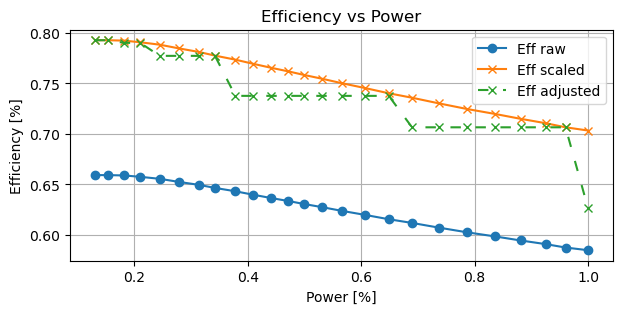

In [44]:
# Plot the data of the original efficiency curve and the adjusted ones
plt.figure(figsize=(7, 3))
plt.plot(df_efficiency_electrolyzer_adj['Power [%]'], df_efficiency_electrolyzer_adj['Efficiency [%]'], label='Eff raw', marker='o')
plt.plot(df_efficiency_electrolyzer_adj['Power [%]'], df_efficiency_electrolyzer_adj['Efficiency_scaled [%]'], label='Eff scaled', marker='x')
plt.plot(df_efficiency_adj['Power [%]'], df_efficiency_adj['eff_adjusted_electrolyzer'], label='Eff adjusted', marker='x', 
         linestyle='dashed', dashes=(5, 7))

plt.xlabel('Power [%]')
plt.ylabel('Efficiency [%]')
plt.title('Efficiency vs Power')
plt.legend()
plt.grid(True)
plt.show()

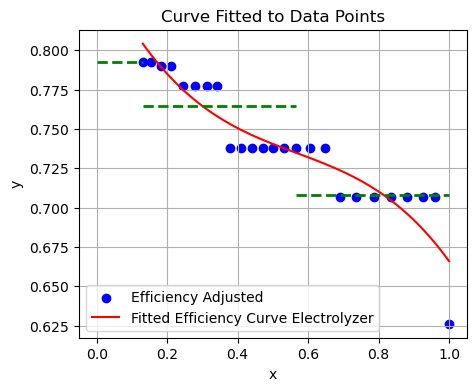

In [45]:
# Plotting the data points and the curve
plt.figure(figsize=(5, 4))
plt.scatter(df_efficiency_electrolyzer_adj['Power [%]'], df_efficiency_electrolyzer_adj['eff_adjusted_electrolyzer'], color='blue', label='Efficiency Adjusted')
plt.plot(x_values_electrolyzer, y_values_electrolyzer, color='red', label='Fitted Efficiency Curve Electrolyzer')

# Plotting segment averages
for i, (x_start, x_end) in enumerate(segment_x_values_electrolyzer):
    plt.plot([x_start, x_end], [segment_averages_electrolyzer[i], segment_averages_electrolyzer[i]], color='green', linestyle='--', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve Fitted to Data Points')
plt.legend()
plt.grid(True)
plt.show()

#### Add operating points to user constraint

In [46]:
###Summarize all variable efficiencies
#Collect all data frames that start with variable_efficiency
dfs = [value for key, value in globals().items() if key.startswith('variable_efficiency') and isinstance(value, pd.DataFrame)]

#Choose the first column with the most segments
longest_df = max(dfs, key=lambda df: df.shape[0])
first_column = longest_df.iloc[:, 0]

#Concatenate the remaining columns from all DataFrames, ensuring no duplicate "first column"
remaining_columns = [df.iloc[:, 1:] for df in dfs]

#Concatenate the remaining columns to the longest first column
df_variable_efficiency = pd.concat([first_column] + remaining_columns, axis=1)
df_variable_efficiency

,relationship_class_name:,unit__from_node__user_constraint,unit__to_node__user_constraint
0,User_constraint_name,EffCurve_Electrolyzer,EffCurve_Electrolyzer
1,Object_name,Electrolyzer,Electrolyzer
2,Node_name,Power_Kasso,Hydrogen_Kasso
3,Parameter,unit_flow_coefficient,unit_flow_coefficient
4,0,0.792754,-1.0
5,1,0.764365,NaN
6,2,0.707758,NaN


In [47]:
# Relate all user_constraints to entity class name "user_constraint" 

Entity_names_duplicate = df_variable_efficiency.iloc[0,1:]
User_constraint_entities = []
for name in Entity_names_duplicate:
    if name not in User_constraint_entities:
        User_constraint_entities.append(name)
        

User_constraint_column = ["user_constraint"]*len(User_constraint_entities)

merged_columns = {"Entity class names": User_constraint_column, "Entity names": User_constraint_entities}
df_variable_eff_def= pd.DataFrame(merged_columns)
df_variable_eff_def

,Entity class names,Entity names
0,user_constraint,EffCurve_Electrolyzer


In [48]:
### Summarize all operating points
#Collect all data frames that start with operating_points
dfs = [value for key, value in globals().items() if key.startswith('operating_points') and isinstance(value, pd.DataFrame)]

#Choose the first column with the most segments
longest_df = max(dfs, key=lambda df: df.shape[0])
first_column = longest_df.iloc[:, 0]

#Concatenate the remaining columns from all DataFrames, ensuring no duplicate "first column"
remaining_columns = [df.iloc[:, 1:] for df in dfs]

#Concatenate the remaining columns to the longest first column
df_operating_points = pd.concat([first_column] + remaining_columns, axis=1)

In [49]:
### Summarize all ordered_unit_flow_op
#Collect all data frames that start with ordered_unit_flow_op
dfs = [value for key, value in globals().items() if key.startswith('ordered_unit_flow_') and isinstance(value, pd.DataFrame)]

#Concatenate the remaining columns to the longest first column
df_boolean_relations = pd.concat(dfs, ignore_index=True)

### Environment and Storages

#### Renewables Availability:

In [50]:
#create table headers and relations
column_names_1 = {'DateTime '+area: [None, None],
                'Solar_Plant_Kasso': ['unit','unit_availability_factor']}
df_blank_table_1 = pd.DataFrame(column_names_1, index=None)

#add values
df_temp_1 = pd.DataFrame(columns=['DateTime ' + area, 'Solar_Plant_Kasso'])
df_temp_1['DateTime '+area] = df_time
df_temp_1['Solar_Plant_Kasso'] = df_PV_availabilityfactors_values['unit_availability_factor']

#fill NaNs on last day by copying previous day (only for leap years)
df_temp_1['Solar_Plant_Kasso_shifted'] = df_temp_1['Solar_Plant_Kasso'].shift(24)
df_temp_1['Solar_Plant_Kasso'] = df_temp_1['Solar_Plant_Kasso'].fillna(df_temp_1['Solar_Plant_Kasso_shifted'])
df_temp_1 = df_temp_1.drop(columns=['Solar_Plant_Kasso_shifted'])

df_table_1 = pd.concat([df_blank_table_1, df_temp_1])

#show table head for control
df_table_1.head()

,DateTime DK1,Solar_Plant_Kasso
0,None,unit
1,None,unit_availability_factor
0,2019-01-01T00:00:00,0.0
1,2019-01-01T01:00:00,0.0
2,2019-01-01T02:00:00,0.0


#### Energy prices:

In [51]:
#adjustemnts of power price variance
#df_powerprices_values['SpotPriceEUR']

# Calculate the current mean and variance
mean = df_powerprices_values['SpotPriceEUR'].mean()
current_variance = df_powerprices_values['SpotPriceEUR'].var()

# Define the new desired variance 
desired_variance = current_variance * power_price_variance

# Calculate the scaling factor
scaling_factor = np.sqrt(desired_variance / current_variance)

# Adjust the time series to achieve the new variance
df_powerprices_values['SpotPriceEUR'] = mean + (df_powerprices_values['SpotPriceEUR'] - mean) * scaling_factor

In [52]:
column_names_2 = {'DateTime ' + area: ['relationship class','connection','node','parameter name'],
                'Power_Wholesale_In': ['connection__from_node','power_line_Wholesale_Kasso','Power_Wholesale','connection_flow_cost'], 
                'Power_Wholesale_Out': ['connection__to_node','power_line_Wholesale_Kasso','Power_Wholesale','connection_flow_cost'], 
                'District_Heating': ['connection__to_node','pipeline_District_Heating','District_Heating','connection_flow_cost']}
df_blank_table_2 = pd.DataFrame(column_names_2, index=None)
df_temp_2 = pd.DataFrame(columns=['DateTime ' + area, 'Power_Wholesale_In', 'Power_Wholesale_Out', 'District_Heating'])

df_temp_2['DateTime ' + area] = df_time
df_temp_2['Power_Wholesale_In'] = price_level_power * df_powerprices_values['SpotPriceEUR']
df_temp_2['Power_Wholesale_Out'] = -1 * price_level_power * df_powerprices_values['SpotPriceEUR']
df_temp_2['District_Heating'] = -1 * df_district_heating_price[str(year)].loc[2] * share_of_dh_price_cap

df_table_2 = pd.concat([df_blank_table_2, df_temp_2], ignore_index=True)

#show table head for control
df_table_2.head()

,DateTime DK1,Power_Wholesale_In,Power_Wholesale_Out,District_Heating
0,relationship class,connection__from_node,connection__to_node,connection__to_node
1,connection,power_line_Wholesale_Kasso,power_line_Wholesale_Kasso,pipeline_District_Heating
2,node,Power_Wholesale,Power_Wholesale,District_Heating
3,parameter name,connection_flow_cost,connection_flow_cost,connection_flow_cost
4,2019-01-01T00:00:00,28.32,-28.32,-18.579088


#### Time Series Storage:

In [53]:
#Date index
start_date = pd.to_datetime(start_date)
before = start_date-timedelta(hours=1)
date_index_beginning = pd.date_range(start=before, end=start_date, freq='H')
formatted_beginning = date_index_beginning.strftime('%Y-%m-%dT%H:%M:%S')
df_formatted_beginning = pd.DataFrame(formatted_beginning, columns=['DateTime'])
df_time_beginning = pd.DataFrame(df_formatted_beginning)
#Add one blank row
new_row = pd.Series([])
df_time_beginning = pd.concat([pd.DataFrame([new_row]), df_time_beginning]).reset_index(drop=True)

#Concat raw data with time index
storage_values = df_model_storages.iloc[:,[0, 1, 2, 6]]
storage_values = storage_values.iloc[:, [0, 3, 1, 2]]
storage_values_transposed = storage_values.T
storage_values_transposed.columns = storage_values_transposed.iloc[0]
storage_values_transposed = storage_values_transposed[1:]
storage_values_transposed.reset_index(drop=True, inplace=True)

df_storage = pd.concat([df_time_beginning, storage_values_transposed], axis=1)

#Show table head for control
df_storage.head()

,DateTime,Hydrogen_storage_Kasso,E-Methanol_storage_Kasso
0,NaN,fix_node_state,fix_node_state
1,2018-12-31T23:00:00,0,0
2,2019-01-01T00:00:00,NaN,NaN


## Creating one combined excel and export

In [54]:
#create the prepared input excel for the use in SpineToolbox
with pd.ExcelWriter(output_file_path + output_file_name) as writer:
    df_definition.to_excel(writer, sheet_name='Definition', index=False)
    unit_parameters_rest_df.to_excel(writer, sheet_name='Definition_parameters', index=False)
    unit_parameters_duration_df.to_excel(writer, sheet_name='Definition_parameters_duration', index=False)
    df_units_inv_parameters.to_excel(writer, sheet_name='Unit_Inv_Parameters', index=False)
    df_nodes.to_excel(writer, sheet_name='Nodes', index=False)
    df_connections_inv_parameters.to_excel(writer, sheet_name='Connection_Inv_Parameters', index=False)
    df_object__node_definitions.to_excel(writer, sheet_name='Object__to_from_node_definition', index=False)
    df_object__node_values.to_excel(writer, sheet_name='Object__to_from_node', index=False)
    df_boolean_relations.to_excel(writer, sheet_name='Boolean_relations', index=False)
    df_object_node_node.to_excel(writer, sheet_name='Object__node_node', index=False)
    df_variable_eff_def.to_excel(writer, sheet_name='Variable_Eff_Definition', index=False)
    df_variable_efficiency.to_excel(writer, sheet_name='Variable_Eff', index=False)
    df_operating_points.to_excel(writer, sheet_name='Operating_points', index=False)
    df_storage.to_excel(writer, sheet_name='Time_series_storage', index=False)
    df_table_1.to_excel(writer, sheet_name='Time_series', index=False)
    df_table_2.to_excel(writer, sheet_name='Energy_prices', index=False)
    df_model_components.to_excel(writer, sheet_name='Model_components', index=False)
    df_model_relations.to_excel(writer, sheet_name='Model_relations', index=False)
    df_model.to_excel(writer, sheet_name='Model', index=False)
    df_temporal_relations.to_excel(writer, sheet_name='Temporal_relations', index=False)

In [55]:
#create output of the mapping excel
with pd.ExcelWriter(output_file_path + output_mapping_file_name) as writer:
    df_model_object_mapping.to_excel(writer, sheet_name='Object_Mapping', index=False)

In [56]:
#copy efficiency
other_name = "other.xlsx"
with pd.ExcelWriter(output_file_path + other_name) as writer:
    df_efficiency_electrolyzer_adj.to_excel(writer, sheet_name='efficiency', index=False)